In [1]:
# view specific predictions made by cnn

import os
from math import floor

import Bio.SeqIO as SeqIO
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import load_model

import sys  
sys.path.append('../../../src')
from metrics import *

from pandas.core.common import flatten

from Bio import SeqIO

from matplotlib import pyplot as plt

In [2]:
model_name = "jason_cnn_10_2"

mobidb_category_to_compare = "P03265|derived-observed-th_90"

fasta_file_path = "../../../data/MobiDB/P03265.fasta"

In [3]:
class BatchGenerator(keras.utils.Sequence):
    """Label, batch, and pad protein sequence data.

    Only complete batches are returned, so a single epoch may not train on every example."""
    def __init__(self, records, batch_size, sym_codes, shuffle=True):
        self.records = records
        self.indices = np.arange(len(self.records))
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.ctable = {}  # Category table
        for i, sym_code in enumerate(sym_codes):
            self.ctable[sym_code] = i
        self.on_epoch_end()

    def __len__(self):
        """Return number of batches."""
        return floor(len(self.records) / self.batch_size)

    def __getitem__(self, index):
        """Generate one batch of data."""
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        records = [self.records[i] for i in indices]
        max_len = max([len(record[0]) for record in records])
        x = np.zeros((self.batch_size, max_len))
        y = np.zeros((self.batch_size, max_len))
        for i, (syms, labels) in enumerate(records):
            x[i, :len(syms)] = [self.ctable.get(sym, 0) for sym in syms]
            y[i, :len(syms)] = [int(label) for label in labels]

        x = keras.utils.to_categorical(x, num_classes=len(self.ctable))
        y = keras.utils.to_categorical(y, num_classes=2)
        for i, (syms, _) in enumerate(records):
            x[i, len(syms):, :] = 0
            y[i, len(syms):, :] = 0
        return x, y

    def on_epoch_end(self):
        """Shuffles data after each epoch."""
        if self.shuffle:
            np.random.shuffle(self.indices)

def decode_sym(batch, sym_codes):
    """Decodes residue symbols in batch of proteins from encoded form."""
    ctable, i = {}, 0
    for sym_code in sym_codes:
        ctable[i] = sym_code
        i += 1
        
    decoded_sym = []
    for protein in batch:
        decoded_protein = []
        for residue in protein:
            if sum(residue) == 0:
                pass
            else:
                decoded_residue = ctable[np.argmax(residue)]
                decoded_protein.append(decoded_residue)
        decoded_sym.append("".join(decoded_protein))
                           
    return decoded_sym

def decode_label_by_protein(batch_to_be_decoded, original_batch):
    """
    Decodes residue labels in batch of proteins from encoded form.
    Outputs list of str where each str is labels of one protein.
    
    batch_to_be_decoded:
    batch of labels which want to be decoded
    
    original_batch:
    original batch of labels generated by BatchGenerator which
    batch_to_be_decoded is derived from (this is needed in order
    to remove unwanted masked values)
    """
    decoded_labels = []
    for x in np.arange(len(original_batch)):
        protein = original_batch[x]
        decoded_protein = []
        for y in np.arange(len(protein)):
            residue = protein[y]
            if sum(residue) == 0:
                pass
            else:
                decoded_residue = np.argmax(batch_to_be_decoded[x][y])
                decoded_protein.append(str(decoded_residue))
        decoded_labels.append("".join(decoded_protein))
    return decoded_labels

def decode_label_to_lst(batch_to_be_decoded, original_batch):
    """
    Decodes residue labels in batch of proteins from encoded form.
    Outputs list of int where each int is label for one residue.
    
    batch_to_be_decoded:
    batch of labels which want to be decoded
    
    original_batch:
    original batch of labels generated by BatchGenerator which
    batch_to_be_decoded is derived from (this is needed in order
    to remove unwanted masked values)
    """
    decoded_labels = []
    for x in np.arange(len(original_batch)):
        protein = original_batch[x]
        for y in np.arange(len(protein)):
            residue = protein[y]
            if sum(residue) == 0:
                pass
            else:
                decoded_residue = np.argmax(batch_to_be_decoded[x][y])
                decoded_labels.append(decoded_residue)
    return decoded_labels
                           
class MaskedConv1D(keras.layers.Conv1D):
    def __init__(self, filters, kernel_size, **kwargs):
        super().__init__(filters, kernel_size, **kwargs)
        self.supports_masking = True
        
def plt_results(results, width, height):
    true = [int(i) for i in results[2]]
    binary_pred = [int(i) for i in results[3]]
    dec_pred_ord = results[4]
    dec_pred_dis = results[5]
    
    x = np.arange(1,len(true)+1)
      
    plt.figure(figsize=(width, height))
    plt.title(results[0] + " Results")
    plt.ylabel("Binary Disorder")
    plt.plot(x, true, color = "black", alpha = 2)
    plt.plot(x, binary_pred, color = "green", alpha = 0.5)
    plt.fill_between(x, binary_pred, color = "green", alpha = 0.2)
    plt.show()
        
    plt.figure(figsize=(width, height))
    plt.title(results[0] + " Decimal Results")
    plt.ylabel("Decimal Results")
    plt.plot(x, true, color = "black", alpha = 2)
    plt.plot(x, dec_pred_ord, color = "blue", alpha = 0.5)
    plt.plot(x, dec_pred_dis, color = "red", alpha = 0.5)
    plt.show()        
    
    plt.figure(figsize=(width, height))
    plt.title(results[0] + " Results")
    plt.ylabel("Dec Order")
    plt.plot(x, true, color = "black", alpha = 2)
    plt.plot(x, dec_pred_ord, color = "blue", alpha = 0.5)
    plt.fill_between(x, dec_pred_ord, color = "blue", alpha = 0.2)
    plt.show()
                 
    plt.figure(figsize=(width, height))
    plt.title(results[0] + " Results")
    plt.ylabel("Dec Disorder")
    plt.plot(x, true, color = "black", alpha = 2)
    plt.plot(x, dec_pred_dis, color = "red", alpha = 0.5)
    plt.fill_between(x, dec_pred_dis, color = "red", alpha = 0.2)
    plt.show()

In [4]:
# Parameters
sym_codes = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
             'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

In [5]:
model = keras.models.load_model("../" + model_name + "/out_model/" + model_name + ".h5", custom_objects={"MaskedConv1D": MaskedConv1D})

In [6]:
records_lst = list(SeqIO.parse(fasta_file_path, "fasta"))

In [7]:
records_dict = {}

for entry in records_lst:
    if "sequence" in entry.description:
        records_dict[entry.description.split("|")[0]] = [str(entry.description), str(entry.seq)]

for entry in records_lst:
    if mobidb_category_to_compare in entry.description:
        records_dict[entry.description.split("|")[0]].append(str(entry.seq))

In [8]:
records_tuple_lst = []

for key in records_dict:
    lst = [records_dict[key][1], records_dict[key][2]]
    records_tuple_lst.append(tuple(lst))

In [9]:
batches = BatchGenerator(records_tuple_lst, 1, sym_codes)

In [10]:
results_lst = []

for key in records_dict:
    results_lst.append(list(records_dict[key]))

for batch in batches:
    sequence = decode_sym(batch[0], sym_codes)[0]
    pred_binary = decode_label_by_protein(model.predict(batch[0]), batch[1])[0]
    
    pred_dec_order = []
    pred_dec_dis = []
    
    for entry in model.predict(batch[0])[0]:
        pred_dec_order.append(entry[0])
        pred_dec_dis.append(entry[1])
    
    for entry in results_lst:
        if entry[1] == sequence:
            entry.append(pred_binary)
            entry.append(pred_dec_order)
            entry.append(pred_dec_dis)

In [11]:
results_lst

[['P03265|sequence|DNA-binding protein OS=Human adenovirus C serotype 5 (HAdV-5) (Human adenovirus 5) OX=28285 GN=DBP',
  'MASREEEQRETTPERGRGAARRPPTMEDVSSPSPSPPPPRAPPKKRMRRRIESEDEEDSSQDALVPRTPSPRPSTSAADLAIAPKKKKKRPSPKPERPPSPEVIVDSEEEREDVALQMVGFSNPPVLIKHGKGGKRTVRRLNEDDPVARGMRTQEEEEEPSEAESEITVMNPLSVPIVSAWEKGMEAARALMDKYHVDNDLKANFKLLPDQVEALAAVCKTWLNEEHRGLQLTFTSKKTFVTMMGRFLQAYLQSFAEVTYKHHEPTGCALWLHRCAEIEGELKCLHGSIMINKEHVIEMDVTSENGQRALKEQSSKAKIVKNRWGRNVVQISNTDARCCVHDAACPANQFSGKSCGMFFSEGAKAQVAFKQIKAFMQALYPNAQTGHGHLLMPLRCECNSKPGHAPFLGRQLPKLTPFALSNAEDLDADLISDKSVLASVHHPALIVFQCCNPVYRNSRAQGGGPNCDFKISAPDLLNALVMVRSLWSENFTELPRMVVPEFKWSTKHQYRNVSLPVAHSDARQNPFDF',
  '000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100000000000000000000000000000000000000000011111111

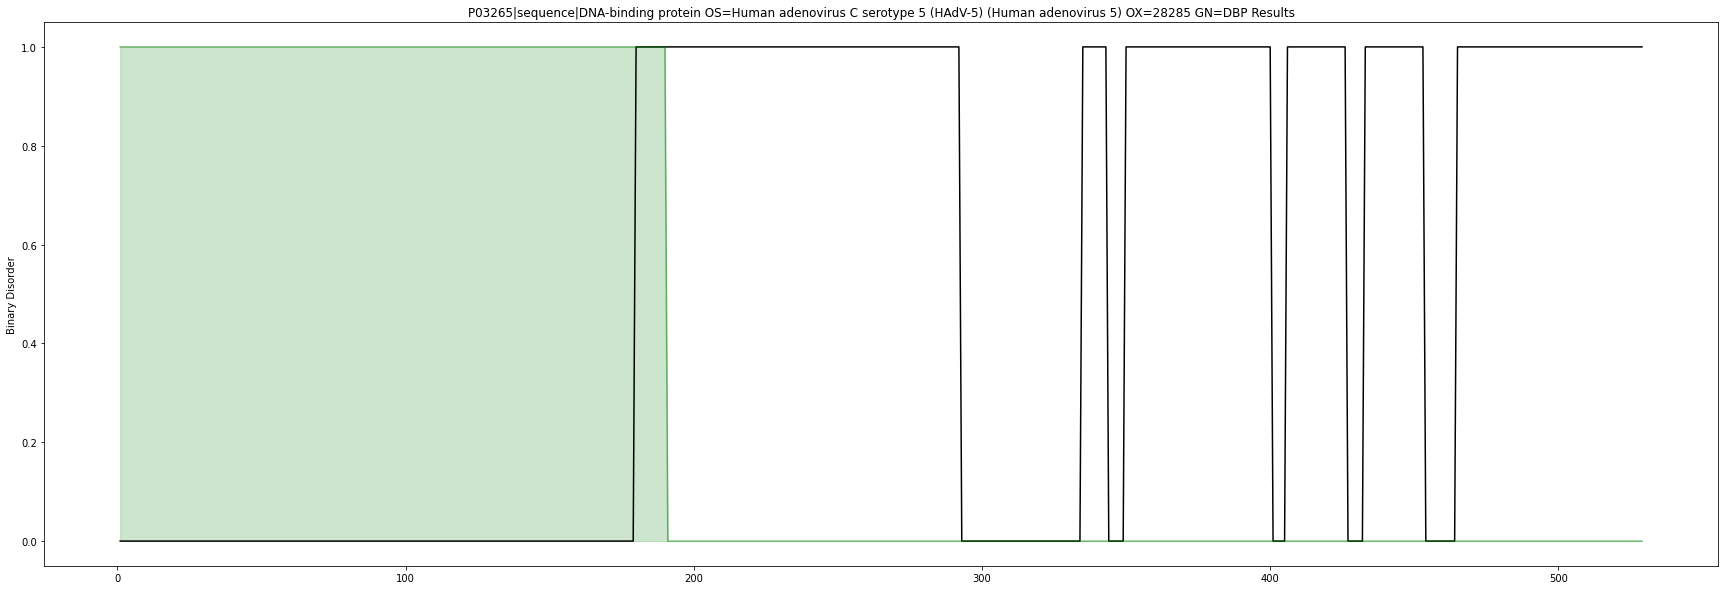

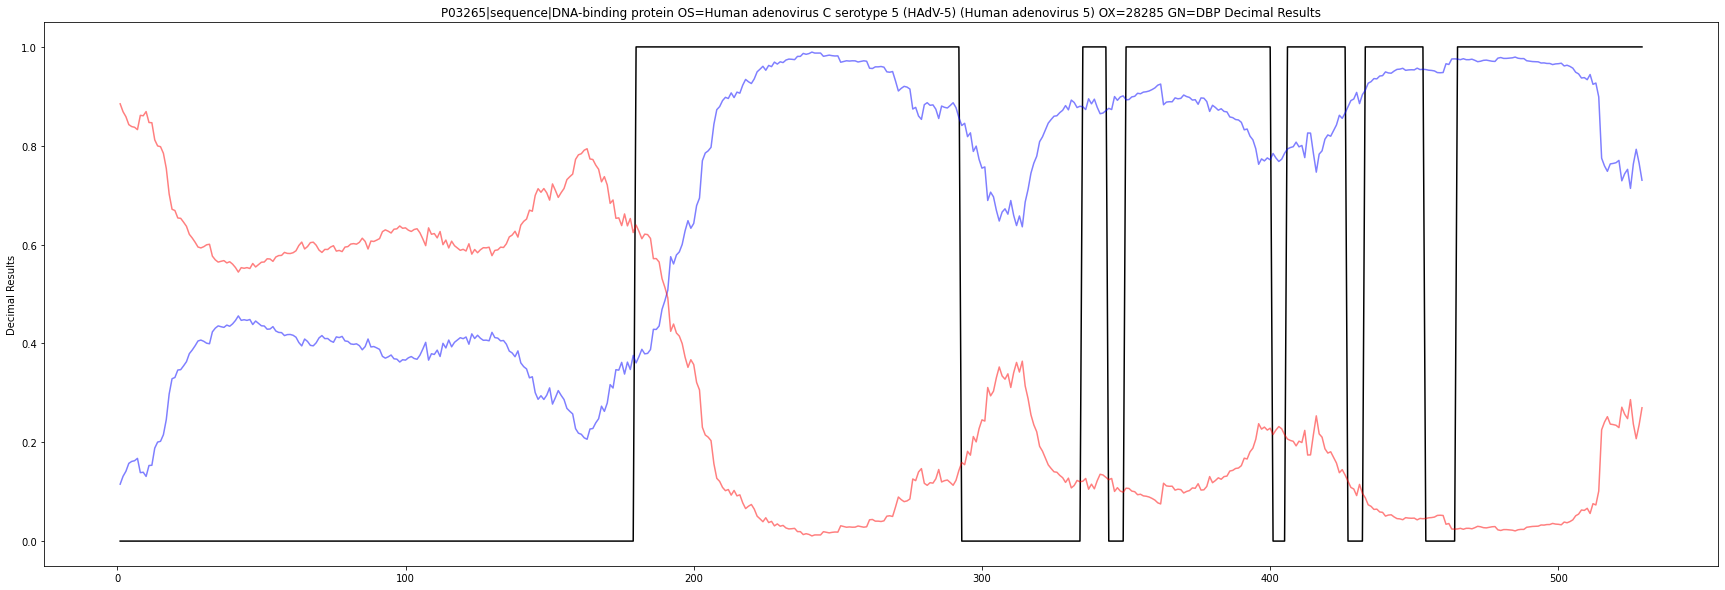

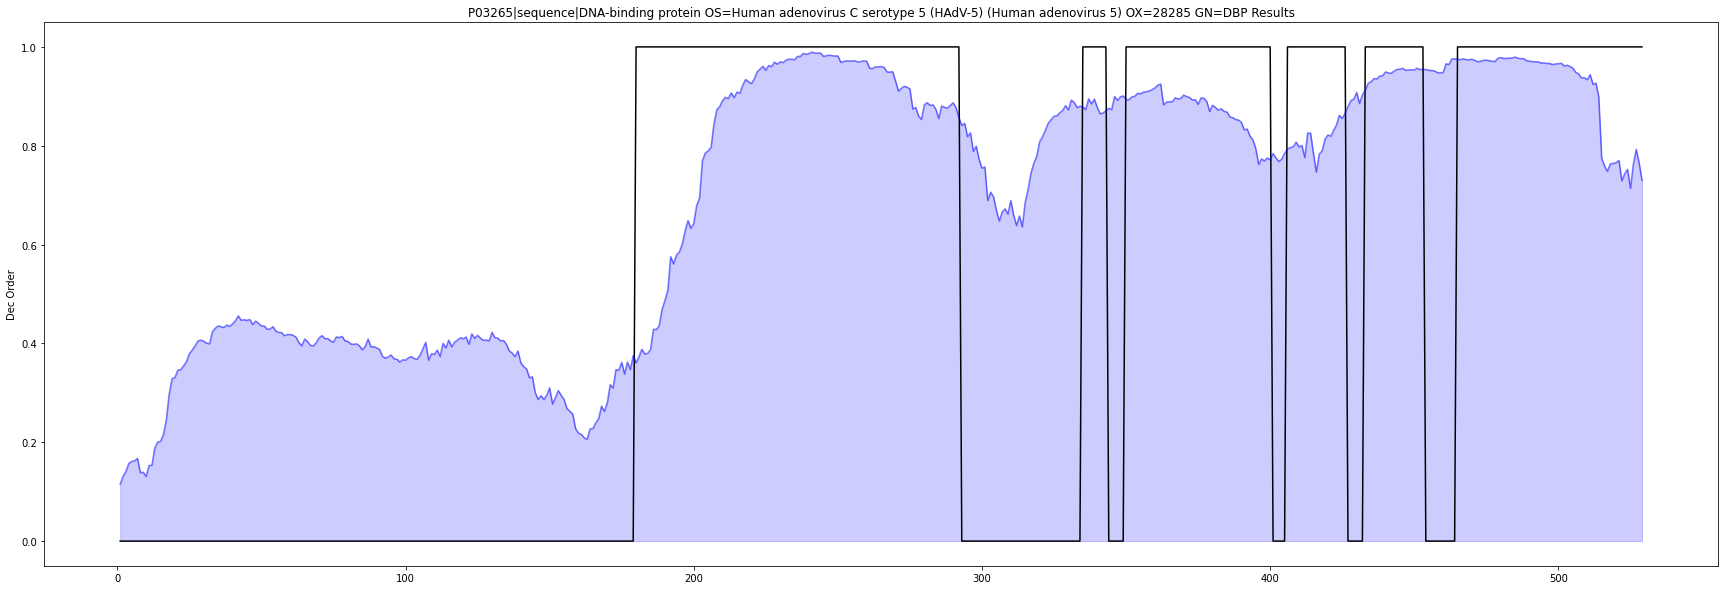

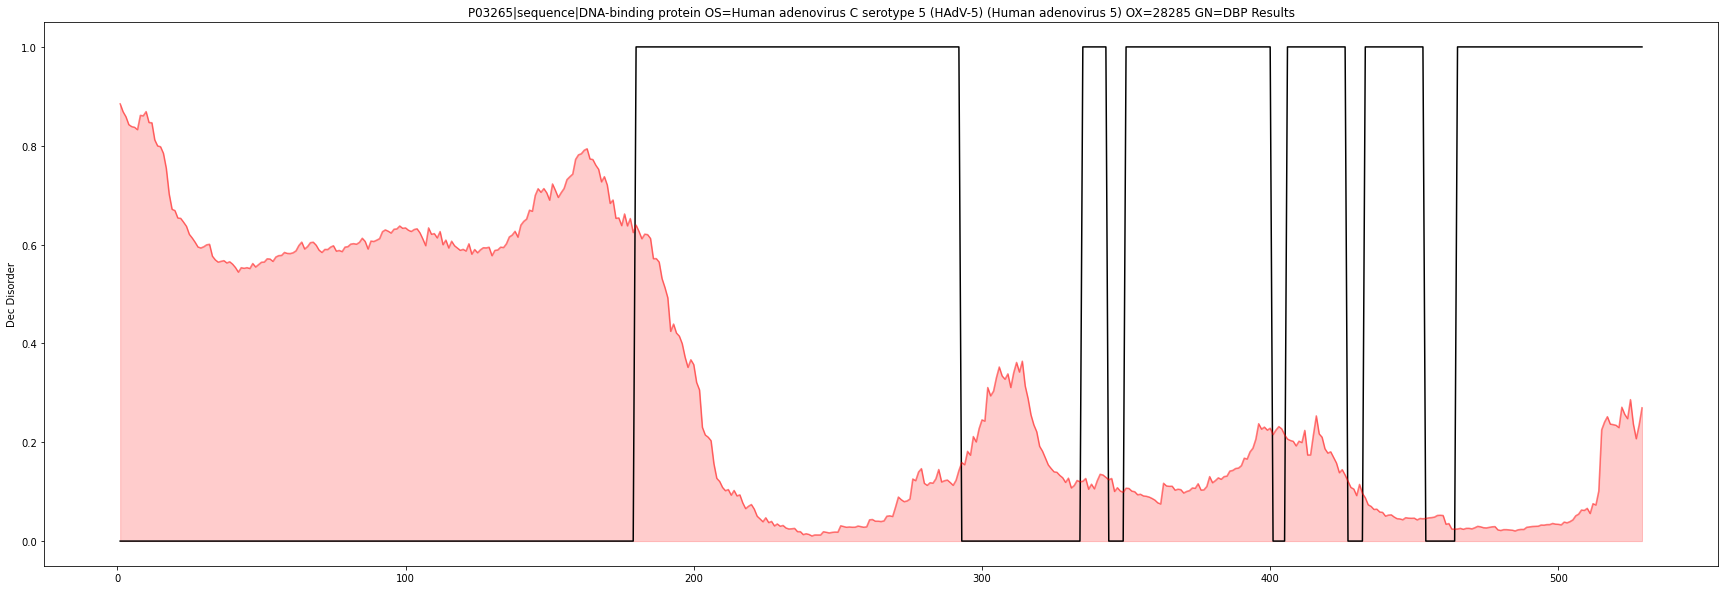

In [12]:
for results in results_lst:
    plt_results(results, 30, 10)